In [365]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import pandas as pd

# Sales approach

In [283]:
df = pd.read_csv('sales_data.csv')
df['sale_date'] = pd.to_datetime(df['sale_date'])
df["quarter"] = df.sale_date.dt.quarter
df["profit"] = (df['regular_price'] - df['purchase_price']) * df['quantity']

def myfunc(q):

    # Filtering by quarter
    my_df = df[df.quarter == q]

    # Grouping by product_id and sum the quantities
    my_df_grouped = my_df.groupby('product_id').sum('quantity')

    # Compute the naive popularity index and scale it
    my_df_grouped['pop_index'] = my_df_grouped['quantity'] / my_df_grouped['quantity'].sum()
    my_df_grouped['pop_index_perc'] = (my_df_grouped['pop_index'] - my_df_grouped['pop_index'].min())\
                                            / (my_df_grouped['pop_index'].max() - my_df_grouped['pop_index'].min())

    # Compute the revenues index and scale it
    my_df_grouped['profit_perc'] = (my_df_grouped['profit'] - my_df_grouped['profit'].min())\
                                            / (my_df_grouped['profit'].max() - my_df_grouped['profit'].min())

    my_df_grouped.reset_index(inplace = True)
    return my_df_grouped

var = myfunc(1)

      product_id  quantity  sales_price_tax  regular_price_tax  sales_price  \
0         100043         3           1377.0             1530.0       1146.0   
1         100044         2           1113.0             1308.0        928.0   
2         100108         1          12990.0            14433.0      10825.0   
3         100122         4           3116.0             3512.0       2596.0   
4         100124         8          21390.0            24800.0      17826.0   
...          ...       ...              ...                ...          ...   
4782      162126         2          15980.0            17756.0      13316.0   
4783      162127         1          10990.0            12211.0       9158.0   
4784      162303         4          11460.0            13288.0       9551.0   
4785      162337         3         373320.0           466644.0     311100.0   
4786      162361         1          25990.0            28878.0      21658.0   

      regular_price  purchase_price  quarter       

In [267]:
def ABC(X):
    top_ten = list(var[var['pop_index_perc'] > X].product_id.unique().tolist())
    my_df = var[var['product_id'].isin(top_ten)].reset_index(drop = True)
    print('Contribution to total revenues of the {} most popular products:'.format(X), my_df.profit.sum()/var.profit.sum())
ABC(0.1)

Contribution to total revenues of the 0.1 most popular products: 0.15404542458145007


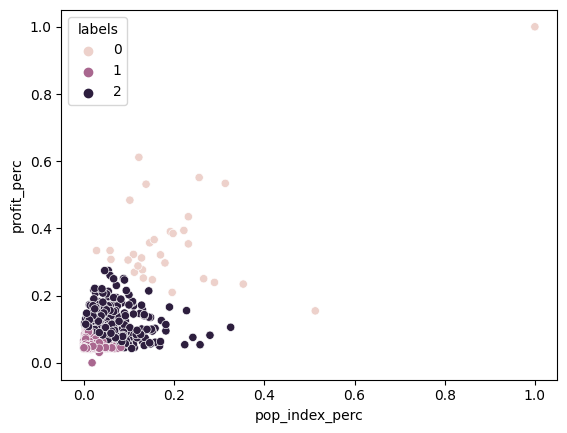

In [282]:
def vincolo_clustering():
    #model = KMeans(n_clusters= 4,
    #               init = 'random')
    model = DBSCAN(eps = 0.05, metric = 'manhattan')
    model.fit(var[['pop_index_perc', 'profit_perc']])
    var['labels'] = model.labels_
    sns.scatterplot(x = var['pop_index_perc'], y=var['profit_perc'], hue = var['labels'])

vincolo_clustering()

In [ ]:
def vincolo_manual():

    var['pop_label'] = 'D'
    for i in range(len(var)):
        if (var['pop_index_perc'][i] > 0.5) & (var['revenues_perc'][i] > 0.5):
            var['pop_label'][i] = 'A'
        elif (var['pop_index_perc'][i] < 0.5) & (var['revenues_perc'][i] > 0.5):
            var['pop_label'][i] = 'B'
        elif (var['pop_index_perc'][i] > 0.5) & (var['revenues_perc'][i] < 0.5):
            var['pop_label'][i] = 'C'

    sns.scatterplot(data=var, x='pop_index_perc', y='revenues_perc', hue='pop_label')

vincolo_manual()

# Click approach

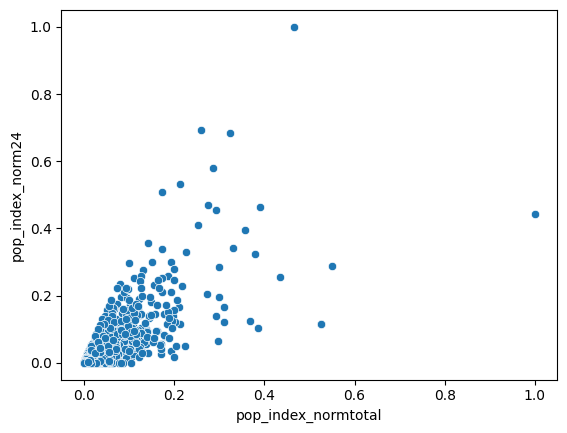

In [375]:
# Import click dataset
df = pd.read_csv('clicks_concatenato.csv', usecols=['date','seller','position','price_max','price_min','price','type','product_id'])
df['date'] = pd.to_datetime(df['date'])
df['quarter'] = df['date'].dt.quarter
df['date'] = df['date'].dt.date

def click(q):

    # Filter by quarter
    copydf = df[df.quarter == q]

    def preprocessing(dataframe):

        # Count the number of click
        total_click = len(dataframe)

        # Group by product_id and count the occurrences
        df_tot = dataframe.groupby('product_id').size().reset_index()
        df_tot.rename(columns = {0: 'click'}, inplace = True)

        # Calculate the popularity index and normalize it
        df_tot['pop_index'] = df_tot['click']/total_click
        df_tot['pop_index_norm'] = (df_tot['pop_index'] - df_tot['pop_index'].min())\
                                            / (df_tot['pop_index'].max() - df_tot['pop_index'].min())
        return df_tot

    # Popularity index of the market
    my_df_tot = preprocessing(copydf)

    # Popularity index for seller 24
    my_df_24 = copydf[copydf['seller'] == 24]
    my_df_24 = preprocessing(my_df_24)

    # Merge the datasets, showing only products sold by s. 24
    final = pd.merge(my_df_tot, my_df_24, on='product_id', how='right', suffixes = ['total','24'])
    sns.scatterplot(data = final, x = 'pop_index_normtotal', y = 'pop_index_norm24')

click(1)